#### Import libraries and data

In [122]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import datetime
import matplotlib.pyplot as plt


data = pd.read_csv("../data/historical_weather.csv")

#### Clean data

In [123]:
# rename columns to readable names
data.rename(columns={
  "temperature_2m_max (°C)": "max_temp",
  "temperature_2m_min (°C)": "min_temp",
  "temperature_2m_mean (°C)": "mean_temp",
  "precipitation_sum (mm)": "precipitation"
}, inplace=True)

# parse date into separate year, month, day
data["year"] = pd.to_datetime(data["time"]).dt.year
data["month"] = pd.to_datetime(data["time"]).dt.month
data["day"] = pd.to_datetime(data["time"]).dt.day

#### Prepare datasets for ML model

In [124]:
# X = input for ML prediction
# y = output for ML prediction
# example: predict temp for 2045-22-23 (X) = 25°C (y)
X = data[["year", "month", "day"]] # input: date
y = data[["mean_temp"]] # output: mean temp
# y = data[["max_temp", "min_temp", "mean_temp", "precipitation"]] # output: temps

# clean data: remove invalid dates
y = y.dropna()
X = X.iloc[y.index]

# generate datasets to train and test model (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Train and test ML model (Linear regression)

In [125]:
# train ML model using linear regression algorithm
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict on train and test datasets
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

# prediction results
lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)
lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2

(60.61571667172436,
 0.04652993672073025,
 60.18164824235202,
 0.04844822089235068)

#### Prediction on real data (future dates)

In [126]:
# generate dates (X) to predict (dates after 2023)
start_date = datetime.date(2023, 1, 1)
end_date = datetime.date(2050, 12, 31)

dates = []
full_dates = []
current_date = start_date
while current_date <= end_date:
  dates.append([current_date.year, current_date.month, current_date.day])
  full_dates.append(current_date.strftime("%Y-%m-%d"))
  current_date += datetime.timedelta(days=1)

# convert dates to dataframe
dates_to_predict = pd.DataFrame(dates, columns=["year", "month", "day"])


#### Predict temperature for future dates

In [127]:
# predict temperatures using ML model (linear regression)
future_temps = lr.predict(dates_to_predict)

# convert to datagrame
future_data = pd.DataFrame({"time": full_dates, "mean_temp": future_temps.flatten()})

## Visualizzare predizioni

#### Dati passati (1940-2022)

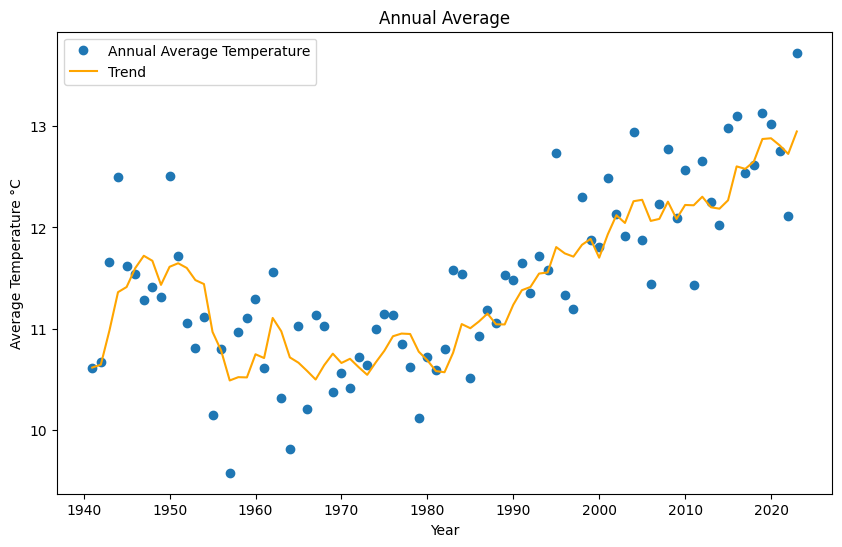

In [128]:
data["time"] = pd.to_datetime(data["time"])
data.set_index("time", inplace=True)

# temperatura media per ogni anno
annual_average = data["mean_temp"].resample("Y").mean()

# trend line
trend_line = annual_average.rolling(window=5, min_periods=1).mean()


plt.figure(figsize=(10, 6))
plt.plot(
  annual_average.index,
  annual_average.values,
  marker="o",
  label="Annual Average Temperature",
  linestyle="none"
)
plt.plot(
  trend_line.index,
  trend_line.values,
  color="orange",
  label="Trend"
)
plt.xlabel("Year")
plt.ylabel("Average Temperature °C")
plt.title("Annual Average")
plt.legend()
plt.show()

#### Dati futuri (2023-2050)

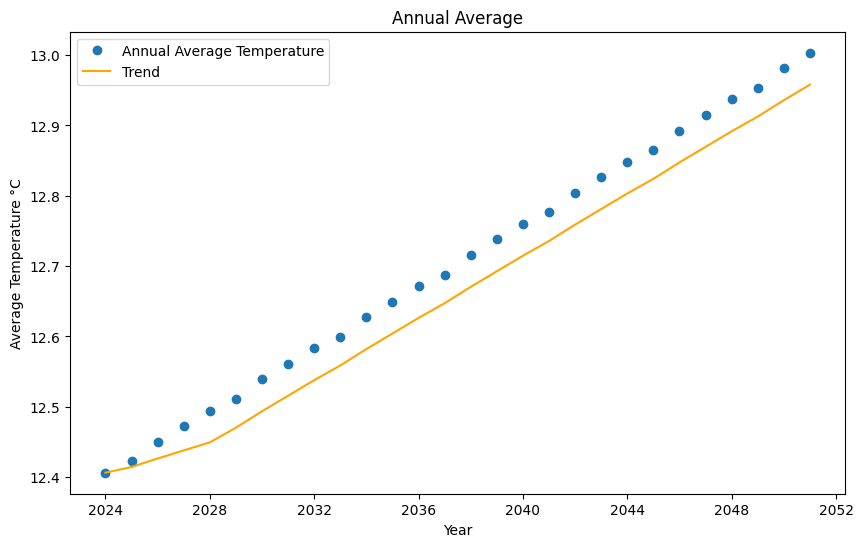

In [129]:
future_data["time"] = pd.to_datetime(future_data["time"])
future_data.set_index("time", inplace=True)

# temperatura media per ogni anno
future_annual_average = future_data["mean_temp"].resample("Y").mean()

# trend line
future_trend_line = future_annual_average.rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(
  future_annual_average.index,
  future_annual_average.values,
  marker="o",
  label="Annual Average Temperature",
  linestyle="none"
)
plt.plot(
  future_trend_line.index,
  future_trend_line.values,
  color="orange",
  label="Trend"
)
plt.xlabel("Year")
plt.ylabel("Average Temperature °C")
plt.title("Annual Average")
plt.legend()
plt.show()

#### Dati combinati (passati + futuri)

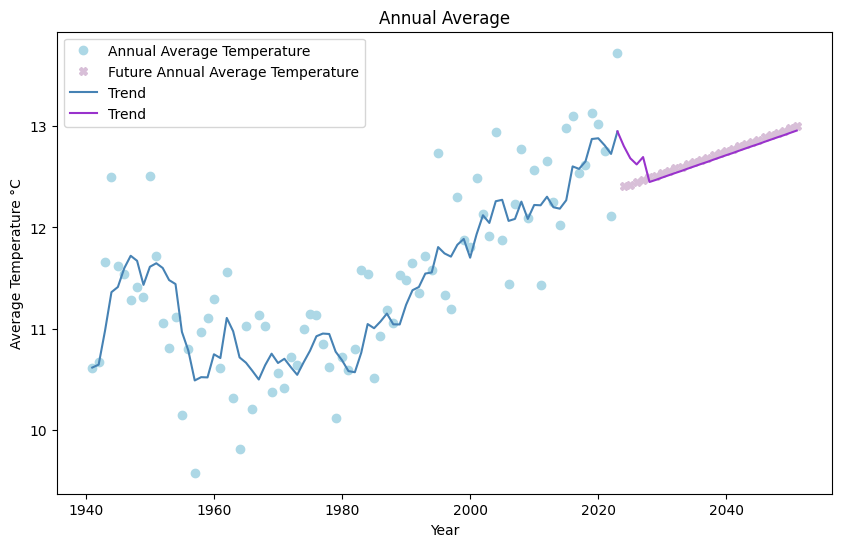

In [130]:
# common trend line
common_average = pd.concat([annual_average, future_annual_average])

common_trend_line = common_average.rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(10, 6))
# past temps
plt.plot(
  annual_average.index,
  annual_average.values,
  marker="o",
  label="Annual Average Temperature",
  linestyle="none",
  color="lightblue"
)
# future temps
plt.plot(
  future_annual_average.index,
  future_annual_average.values,
  label="Future Annual Average Temperature",
  marker="X",
  linestyle="none",
  color="thistle"
)
# past trend
plt.plot(
  common_trend_line[:"2022-12-31"].index,
  common_trend_line[:"2022-12-31"].values,
  label="Trend",
  color="steelblue"
)
# future trend
plt.plot(
  common_trend_line["2022-12-31":].index,
  common_trend_line["2022-12-31":].values,
  label="Trend",
  color="darkorchid"
)
plt.xlabel("Year")
plt.ylabel("Average Temperature °C")
plt.title("Annual Average")
plt.legend()
plt.show()